<a href="https://colab.research.google.com/github/franz6ko/vision-artificial-2/blob/master/Clase-3/VGG16_con_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-08-06 14:00:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   105MB/s    in 0.6s    

2021-08-06 14:00:29 (105 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

In [3]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
import numpy as np

In [93]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"
trdata = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)
traindata = trdata.flow_from_directory(directory=train_dir,target_size=(224,224), batch_size=20, class_mode='binary')
tsdata = ImageDataGenerator(rescale = 1./255)
testdata = tsdata.flow_from_directory(directory=validation_dir, target_size=(224,224), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Reescribir la red utilizando el método funcional y definiendo una función de ayuda.

In [103]:
# model = Sequential()
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=2, activation="softmax"))

def create_block(n_filters, n_layers, inputs):
    '''
    Entradas:
     n_filters: numero de filtros del bloque
     n_layers: número de capas del bloque
     inputs: tensor de entrada
    Retorna:
     tensor de salida con las capas aplicadas
    '''
    for i in range(n_layers):
      inputs = Conv2D(filters=n_filters,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer='he_uniform')(inputs)
    inputs = MaxPool2D(pool_size=(2,2),strides=(2,2))(inputs)
    return inputs
    
inputs = Input(shape=(224,224,3))
x = create_block(64,2,inputs)
x = create_block(128,2,x)
x = create_block(256,3,x)
x = create_block(512,3,x)
x = create_block(512,3,x)
x = Flatten()(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)
outputs = Dense(units=1, activation="sigmoid")(x)
model = Model(inputs, outputs)

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss=binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 56, 56, 128)       0  

In [104]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(True)

In [105]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [106]:
hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data=testdata, validation_steps=10, epochs=20, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 38s 370ms/step - loss: 0.7041 - accuracy: 0.5110 - val_loss: 0.6794 - val_accuracy: 0.5600

Epoch 00001: val_accuracy improved from -inf to 0.56000, saving model to vgg16_1.h5
Epoch 2/20
100/100 [==============================] - 38s 382ms/step - loss: 0.6760 - accuracy: 0.5845 - val_loss: 0.6332 - val_accuracy: 0.7150

Epoch 00002: val_accuracy improved from 0.56000 to 0.71500, saving model to vgg16_1.h5
Epoch 3/20
100/100 [==============================] - 38s 375ms/step - loss: 0.6629 - accuracy: 0.5985 - val_loss: 0.6442 - val_accuracy: 0.6350

Epoch 00003: val_accuracy did not improve from 0.71500
Epoch 4/20
100/100 [==============================] - 38s 380ms/step - loss: 0.6552 - accuracy: 0.6160 - val_loss: 0.5803 - val_accuracy: 0.6800

Epoch 00004: val_accuracy did not improve from 0.71500
Epoch 5/20
100/100 [==============================] - 37s 371ms/step - loss: 0.6404 - accuracy: 0.6300 - val_loss: 0.5996 - val_accurac

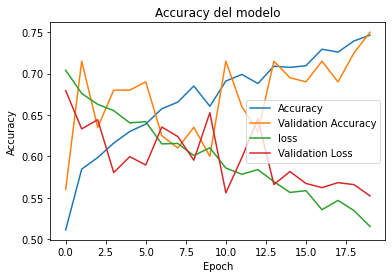

In [107]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Accuracy del modelo")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

cat


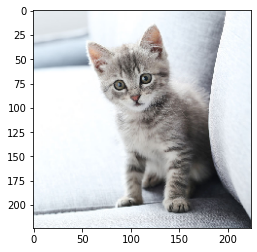

In [116]:
from tensorflow.keras.preprocessing import image
# bajar una imagen de ejemplo de internet
img = image.load_img("cat.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] < 0.5:
    print("cat")
else:
    print('dog')

dog


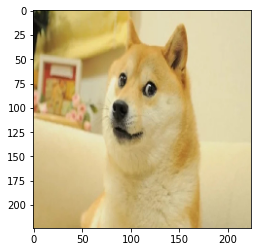

In [117]:
from tensorflow.keras.preprocessing import image
# bajar una imagen de ejemplo de internet
img = image.load_img("dog.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] < 0.5:
    print("cat")
else:
    print('dog')